Upload CONTENT image (photo):


Saving contente.jpg to contente.jpg

Upload STYLE image (artwork):


Saving stylee.jpg to stylee.jpg
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Starting training...
Iter    0 | Loss: 3.42e+09 | Time: 3.0s
Iter  100 | Loss: 1.12e+08 | Time: 9.1s
Iter  200 | Loss: 1.01e+08 | Time: 15.3s
Iter  300 | Loss: 9.73e+07 | Time: 21.6s
Iter  400 | Loss: 9.51e+07 | Time: 27.9s
Iter  500 | Loss: 9.53e+07 | Time: 34.3s
Iter  600 | Loss: 9.62e+07 | Time: 40.7s
Iter  700 | Loss: 9.26e+07 | Time: 47.2s
Iter  800 | Loss: 9.50e+07 | Time: 53.8s
Iter  900 | Loss: 9.26e+07 | Time: 60.5s
Iter 1000 | Loss: 9.37e+07 | Time: 67.3s
Iter 1100 | Loss: 9.44e+07 | Time: 74.2s
Iter 1200 | Loss: 9.01e+07 | Time: 81.2s
Iter 1300 | Loss: 9.11e+07 | Time: 88.1s
Iter 1400 | Loss: 9.34e+07 | Time: 95.0s
Iter 1500 | Loss: 9.01e+07 | Time: 101.7s
Iter 1600 | Loss: 9.00e+07 | Time: 108.4s
Iter 1700 | Loss: 9.18e+07 | Time: 115.0s
Iter 1800 | Loss: 8.99e+07 | Time: 121.6s
Iter 1900 | Loss: 8.85e+07 | Time: 128.2s


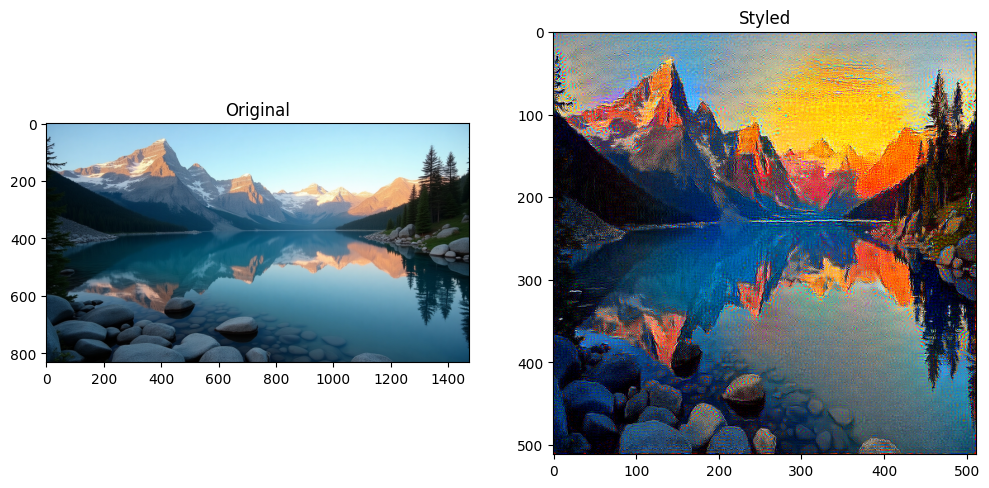

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Style transfer complete! Saved to result.jpg


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt
from google.colab import files
import os
import time
from PIL import Image


!rm -f contente.jpg stylee.jpg

print("Upload CONTENT image (photo):")
content_path = list(files.upload().keys())[0]
os.rename(content_path, "contente.jpg")

print("\nUpload STYLE image (artwork):")
style_path = list(files.upload().keys())[0]
os.rename(style_path, "stylee.jpg")


def load_and_preprocess(path, target_size=(512, 512)):
    img = load_img(path, target_size=target_size)
    arr = img_to_array(img)[..., :3]  # Remove alpha if PNG
    arr = tf.keras.applications.vgg19.preprocess_input(arr)
    return tf.expand_dims(arr, axis=0)  # Add batch dimension

content_tensor = load_and_preprocess("contente.jpg")
style_tensor = load_and_preprocess("stylee.jpg")
generated_image = tf.Variable(content_tensor)  # Now shape (1,512,512,3)

#   MODEL SETUP
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']
content_layer = 'block4_conv2'
outputs = [vgg.get_layer(name).output for name in style_layers + [content_layer]]
model = tf.keras.Model(vgg.input, outputs)

style_outputs = model(style_tensor)[:3]
content_output = model(content_tensor)[3]

def gram_matrix(x):
    x = tf.reshape(x, [-1, x.shape[-1]])
    return tf.matmul(x, x, transpose_a=True) / tf.cast(tf.size(x), tf.float32)

gram_style_targets = [gram_matrix(style_output) for style_output in style_outputs]


style_weight = 1e5
content_weight = 1e3
iterations = 2000

def compute_loss(outputs):
    style_loss = tf.add_n([
        tf.reduce_mean((gram_matrix(outputs[i]) - gram_style_targets[i])**2)
        for i in range(3)
    ]) * style_weight

    content_loss = tf.reduce_mean((outputs[3] - content_output)**2) * content_weight
    return style_loss + content_loss

opt = tf.optimizers.Adam(learning_rate=10.0)

@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = model(image)
        loss = compute_loss(outputs)
    grads = tape.gradient(loss, image)
    opt.apply_gradients([(grads, image)])
    return loss

print("Starting training...")
start_time = time.time()
for i in range(iterations):
    loss = train_step(generated_image)
    if i % 100 == 0:
        print(f"Iter {i:4d} | Loss: {loss:.2e} | Time: {time.time()-start_time:.1f}s")

# RESULTS
def deprocess(x):
    x = x.numpy().squeeze()
    x += [103.939, 116.779, 123.68]
    x = np.clip(x[..., ::-1], 0, 255).astype('uint8')
    return x

final_image = deprocess(generated_image)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(load_img("contente.jpg"))
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title("Styled")
plt.show()


output_path = "result.jpg"
Image.fromarray(final_image).save(output_path, quality=95)
files.download(output_path)

print(f" Style transfer complete! Saved to {output_path}")